# 02) TF–IDF baseline

This notebook creates a baseline model using TF-IDF and logistic regression. A regression model is used to allow for dynamic altering of the risk headline classification threshold in another program. The primary business goal of this project is to create a model with a high risk headline recall. Although the overall accuracy for the Spanish and Portuguese models isn't too bad for a baseline model, the recall for both of them in terms of risk headlines is poor, likely due to the presence of mislabelled data. 

## Read-in data

In [1]:
import pandas as pd
import numpy as np

# read-in data
df = pd.read_csv('../Data/original_headlines.csv', encoding='utf-8')
print(str(round(len(df)/1000, 1)) + 'K Total headlines')

# include only spanish 
spanish_df = df[df.country.isin(['Argentina', 'Colombia', 'Mexico'])].reset_index(drop=True)
print(str(round(len(spanish_df)/1000, 1)) + 'K Spanish headlines')

# include only portuguese 
portuguese_df = df[df.country == 'Brazil'].reset_index(drop=True)
print(str(round(len(portuguese_df)/1000, 1)) + 'K Portuguese headlines')

95.2K Total headlines
77.3K Spanish headlines
15.2K Portuguese headlines


## Remove duplicates & thumbnails

Headlines containing the word thumbnail are normally videos which cannot be scraped. Many of these with a similar format in the non-risk headlines data add little value in terms of variety and therefore are removed.

In [2]:
# remove duplicates
spanish_df.drop_duplicates(subset='headline', inplace=True)
portuguese_df.drop_duplicates(subset='headline', inplace=True)

# remove thumbnails
spanish_df = spanish_df[~spanish_df['headline'].str.lower().str.contains('thumbnail', na=False)]
portuguese_df = portuguese_df[~portuguese_df['headline'].str.lower().str.contains('thumbnail', na=False)]

# removes english headlines from the spanish dataset
spanish_df = spanish_df.loc[~spanish_df.website.isin(['Colombia Reports'])]

# reset index
spanish_df.reset_index(drop=True, inplace=True)
portuguese_df.reset_index(drop=True, inplace=True)

## Clean text

The text is subjected to common cleaning techniques to reduce dimensionality.

In [3]:
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

# common text cleaning techniques
def clean_text(text, language='Spanish'):
    text = text.strip()
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation + '¡¿'))
    stop_words = set(stopwords.words(language))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jack-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Fit model

A model is fit using TF-IDF vectors and logistic regression. A regression model is used to obtain probabilities so that the classification threshold can be easily varied. 

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# vectorizes data
def vectorize_data(X_train, X_test=None, train_only=False):
    if train_only==True:
        vectorizer = TfidfVectorizer()
        X_train_tfidf = vectorizer.fit_transform(X_train)
        return X_train_tfidf
    else:
        vectorizer = TfidfVectorizer()
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        return X_train_tfidf, X_test_tfidf

# fits a model 
def fit_model(X_train_tfidf, y_train):
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)
    return model

## Train test split

Creates a train test split for a given dataframe.

In [5]:
from sklearn.model_selection import train_test_split

# returns a train test split
def split_data(df):
    X = df.headline
    y = [int(pd.notna(x)) for x in df.risk_type]
    return train_test_split(X, y, test_size=0.25, stratify=y)

## Evaluate model

Prints the accuracy and classification report for a given model on a given set of headlines.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# creates a confusion matrix heatmap
def heatmap(conf_matrix_df, colors):
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix_df, annot=True, cmap=colors, fmt='d', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# evaluates a model by printing the accuracy and classification report
def evaluate_model(model, X_test_tfidf, y_test, colors):
    y_pred = model.predict(X_test_tfidf)
    y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1] 
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print()
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print()
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Non-Risk', 'Actual Risk'], columns=['Pred Non-Risk', 'Pred Risk'])
    heatmap(conf_matrix_df, colors)
    print()

## Compare results

Compares the the performance of both languages. The results indicate that most important metric of this project from a business perspective, risk headlines recall, is very low for both languages (0.44 and 0.38), possibly due to the presence of mislabelled data.


*** Spanish ***

Accuracy: 0.9148340430496412

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     14774
           1       0.85      0.47      0.60      2369

    accuracy                           0.91     17143
   macro avg       0.88      0.73      0.78     17143
weighted avg       0.91      0.91      0.90     17143




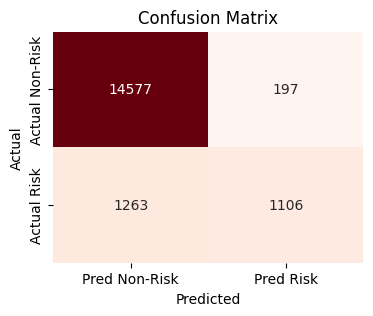




*** Portuguese ***

Accuracy: 0.8354395604395605

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90      2806
           1       0.80      0.37      0.51       834

    accuracy                           0.84      3640
   macro avg       0.82      0.67      0.71      3640
weighted avg       0.83      0.84      0.81      3640




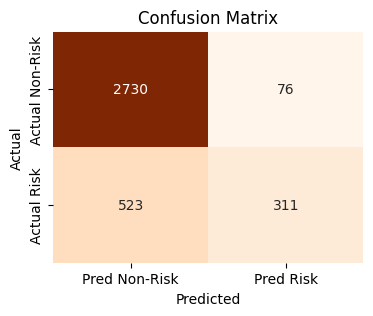

In [7]:
# cleans the headlines vectorizes the text and evaluates the model
def clean_train_evaluate(language, colors):
    df = eval(language + '_df')
    df['headline'] = df['headline'].apply(clean_text, language=language)
    X_train, X_test, y_train, y_test = split_data(df)
    X_train_tfidf, X_test_tfidf = vectorize_data(X_train, X_test)
    model = fit_model(X_train_tfidf, y_train)
    evaluate_model(model, X_test_tfidf, y_test, colors)

languages = ['spanish', 'portuguese']
colors = ['Reds', 'Oranges']
for i, language in enumerate(languages):
    print()
    print('*** ' + language.title() + ' ***')
    print()
    clean_train_evaluate(language, colors[i])
    print()

## Test headlines

A new headline deemed by Gemini as a potential business risk according to our criteria returns a very low probability from the model...

In [8]:
# The following headline is deemed a risk headline that this model fails to predict...
test_headline = 'Inversiones en sistema eléctrico, insuficientes para satisfacer la creciente demanda: IMCO'

df = spanish_df
X_train, X_test, y_train, y_test = split_data(df)
X_train_tfidf, X_test_tfidf = vectorize_data(X_train, X_test)
model = fit_model(X_train_tfidf, y_train)

vectorizer = TfidfVectorizer()
vectorizer.fit_transform(X_train)
cleaned_text = list(clean_text(test_headline, language='spanish'))
test_vector = vectorizer.transform(cleaned_text)

y_pred = model.predict(test_vector)
y_pred_prob = model.predict_proba(test_vector)[:, 1] 
np.mean(y_pred_prob)

0.05484439345340002

## Save model

The model is saved for comparison purposes later on.

In [9]:
import pickle

filename = '../Models/tfidf_baseline.pkl'

with open(filename, 'wb') as file:
    pickle.dump(model, file)